# Chosing Top Real Estate Zipcodes


## Load Data

In [81]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
import statistics as stats
from matplotlib.pylab import rcParams
from pandas import Grouper
from collections import Counter
plt.style.use('seaborn-bright')

import warnings
warnings.filterwarnings('ignore')

Data Preview:

In [82]:
# read in data and preview
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Preprocessing

In [83]:
# Convert all data columns to type: float
for c in df.columns[7:]:
    df[c] = df[c].astype(float)
c_entries = len(df.RegionID)
n_entries = df.size
nan_entries = df.isna().sum().sum()
print('Entries per column:                    '  , c_entries)
print('Total entries:                         '  , n_entries)
print('Total NaN entries:                     '  , nan_entries)

# Check for columns for NaNs entries greater than 10%
print('Percent of NaN entries:                '  , round(nan_entries/n_entries, 2))
print('Columns with 5% or more NaN Entries:   '  ,    (df.isna().sum()/c_entries > .05).sum())
print('Columns with 10% or more NaN Entries:  '  ,    (df.isna().sum()/c_entries > .1).sum())

Entries per column:                     14723
Total entries:                          4004656
Total NaN entries:                      157934
Percent of NaN entries:                 0.04
Columns with 5% or more NaN Entries:    112
Columns with 10% or more NaN Entries:   0


In [84]:
# convert columns with dates to datetime format

pd.to_datetime(df.columns.values[7:], format='%Y-%m')

#make a copy of the dataframe
df_c = df.copy()

In [85]:
# count how many intervals are increasing in value

increasing_zips = []
increasing_rank = []
for row in range(c_entries):
    entry_0 = 0
    increasing = 0
    decreasing = 0
    n_increasing = 0
    zipcode = df_c.RegionName[row]
    for column_name in df.columns[7:]:
        entry_1 = df_c[column_name][row]
        if entry_1 > entry_0:
            increasing += 1
        else:
            decreasing += 1 
        entry_0 = entry_1
    n_increasing = increasing - decreasing
    if n_increasing > 0:
        increasing_zips.append(zipcode)
        increasing_rank.append(n_increasing)

In [86]:
# filter the zipcodes with 70% of intervals are positive.

d = {'Zipcode':increasing_zips,'Rank': increasing_rank}
increasing_df = pd.DataFrame(d)
rank_cutoff = 0.7 * (len(df.columns)-7)
print(rank_cutoff)
zips_df = increasing_df.sort_values(by='Rank',ascending=False)[0:15]
zips = list(zips_df['Zipcode'])

# create a dataframe 
df_c = df_c[df_c.RegionName.isin(zips)]

185.5


In [87]:

# Compute % change for the last few years to choose 
# zipcodes with greatest potential for growth in the 
# coming years.

df_c['delta1'] =  (df_c['2018-04'] - df_c['2017-12'])/(df_c['2017-12'])
df_c['delta2'] =  (df_c['2018-04'] - df_c['2017-04'])/(df_c['2017-04'])
df_c['delta3'] =  (df_c['2017-04'] - df_c['2016-04'])/(df_c['2016-04'])
df_c['delta4'] =  (df_c['2016-04'] - df_c['2015-04'])/(df_c['2015-04'])

# Created a filter to extract zipcodes 
d1 = df_c[(df_c.delta1 >= .02)  & (df_c.delta1 <= .10) & 
          (df_c.delta2 >= .02)  & 
          (df_c.delta3 >= 0)    &
          (df_c.delta4 >= 0)].sort_values(by='delta1',ascending=False)

# create a list with the zipcodes that satisfy above criteria
zips = list(d1.RegionName)
zips

[80904, 80212, 11221, 80211, 80210, 11216, 37216, 80521, 20009]

In [88]:
# filter out zipcodes with standard deviations greater than a threshhold.
zips_filt = []
for z in zips:
    df_z = df_c[df_c.RegionName==z]
    ts = df_z.values[0][7:]
    std = np.std(ts)
    if (std  < 110000):
        zips_filt.append(z)

len(zips_filt)


5

In [89]:
# define a function to convert from long format to short format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','SizeRank','RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time',inplace=True)
    melted.dropna(inplace=True)
    return melted
    #return melted.groupby('time').aggregate({'value':'mean'})

In [90]:
# create a short format dataframe to hold data for top zipcodes
zip_df = pd.DataFrame()
for z in zips_filt:
    d = melt_data(df[df.RegionName==z])
    zip_df = pd.concat([d,zip_df])
zip_df.head()

,RegionID,SizeRank,RegionName,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,113900.0
1996-05-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,114200.0
1996-06-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,114400.0
1996-07-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,114700.0
1996-08-01,93445,2492,80521,Fort Collins,CO,Fort Collins,Larimer,115000.0


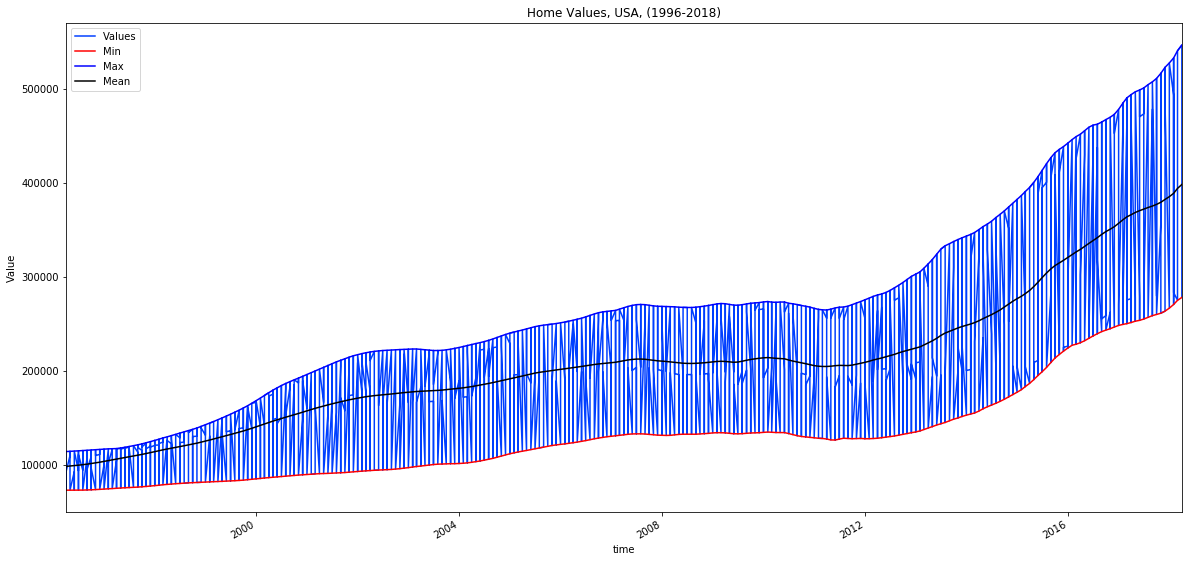

In [91]:
# plot the entirety of data for all zipcodes and observe overall trend
# make sure this satisfies criteria: (Low STD and overall increasing trend)

zip_df.value.plot(figsize=(20,10),label='Values')
min_ = zip_df.groupby('time').aggregate({'value':'min'})
max_ = zip_df.groupby('time').aggregate({'value':'max'})
mean_ = zip_df.groupby('time').aggregate({'value':'mean'})
plt.plot(min_, color= 'red',label='Min')
plt.plot(max_, color='blue',label = 'Max')
plt.plot(mean_, color= 'black',label= 'Mean')
plt.legend()
plt.title('Home Values, USA, (1996-2018)')
plt.ylabel('Value')
plt.show()

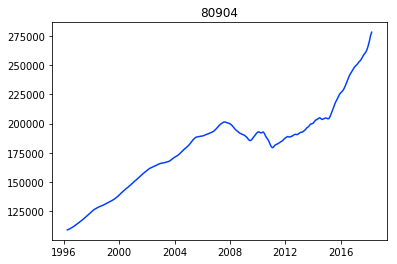

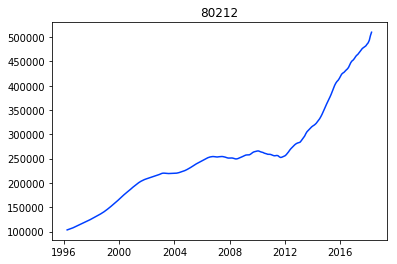

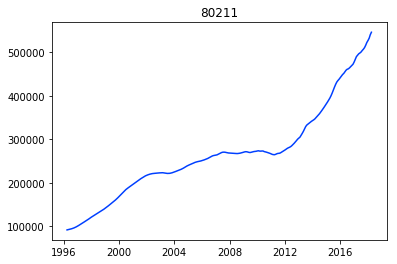

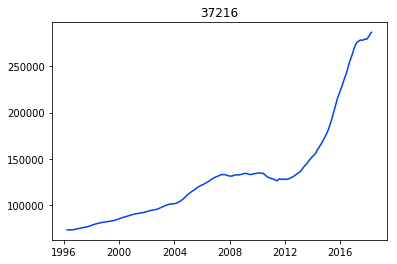

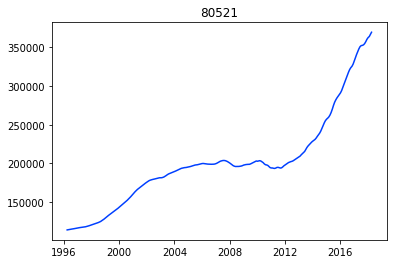

In [92]:
# create plots for QC each zipcode 

for z in zips_filt:
    df_z = zip_df[zip_df.RegionName == z]
    ts = df_z.value
    plt.plot(ts)
    plt.title(z)
    plt.show()


All looks good

# Step 3: EDA and Visualization

Understand amount of missing entries:

In [93]:
# Create lists for each geographical division.
states = zip_df.State.sort_values().unique()
metros = zip_df.Metro.sort_values().unique()
cities = zip_df.City.sort_values().unique()
zipcodes = zip_df.RegionName.sort_values().unique()

# print number of geographical divisions
print('In this dataset, we have information for: ')
print('States: ', len(states), ', Metros: ',len(metros), ', Cities: ' , len(cities), ', Zipcodes: ', len(zipcodes))

In this dataset, we have information for: 
States:  2 , Metros:  4 , Cities:  4 , Zipcodes:  5


In [94]:
print(states, metros, cities, zipcodes)

['CO' 'TN'] ['Colorado Springs' 'Denver' 'Fort Collins' 'Nashville'] ['Colorado Springs' 'Denver' 'Fort Collins' 'Nashville'] [37216 80211 80212 80521 80904]


# Step 5: ARIMA Modeling

In [95]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
    result = adfuller(df_z.value.dropna())
    print('Zip: ', z)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

Zip:  37216
ADF Statistic: -0.281540
p-value: 0.928078
Zip:  80211
ADF Statistic: 1.385263
p-value: 0.997046
Zip:  80212
ADF Statistic: 1.105638
p-value: 0.995264
Zip:  80521
ADF Statistic: 0.196868
p-value: 0.972085
Zip:  80904
ADF Statistic: 0.899414
p-value: 0.993083


None of the series are stationary.

ZIPCODE:  37216


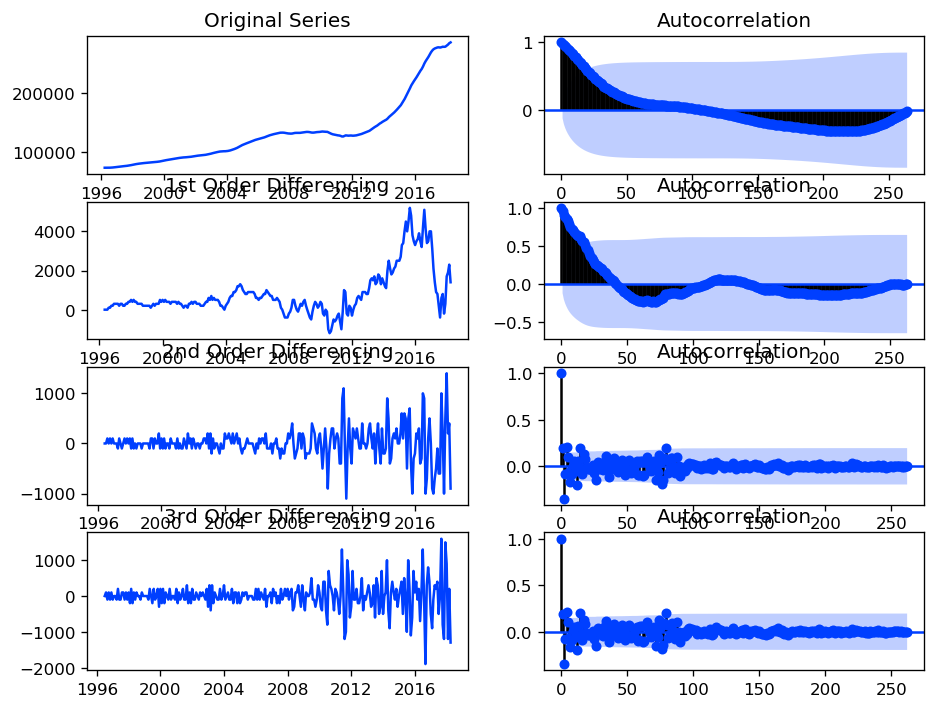

ZIPCODE:  80211


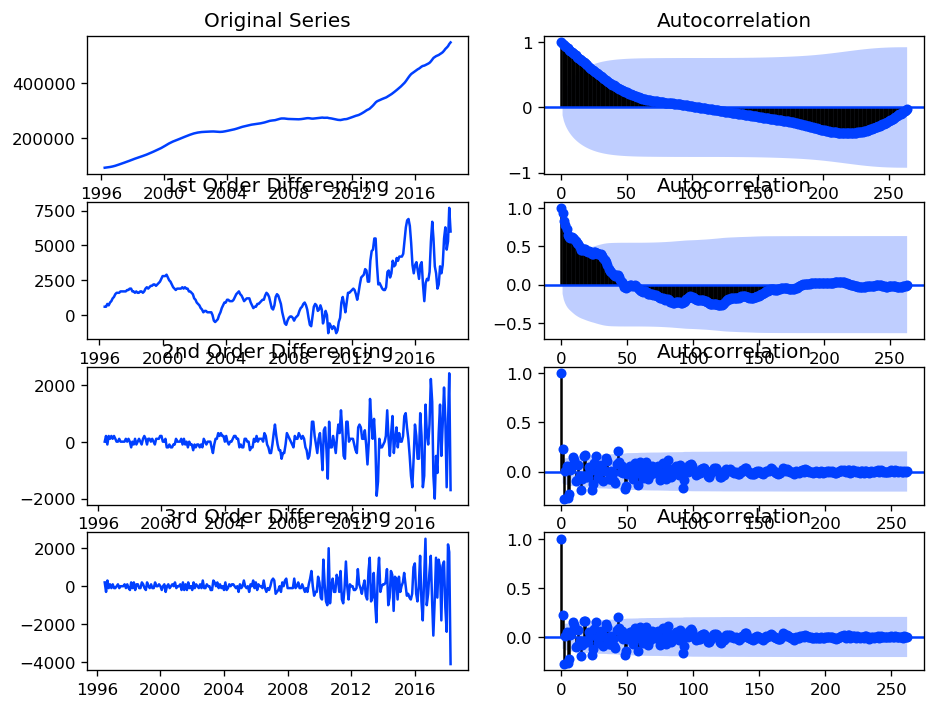

ZIPCODE:  80212


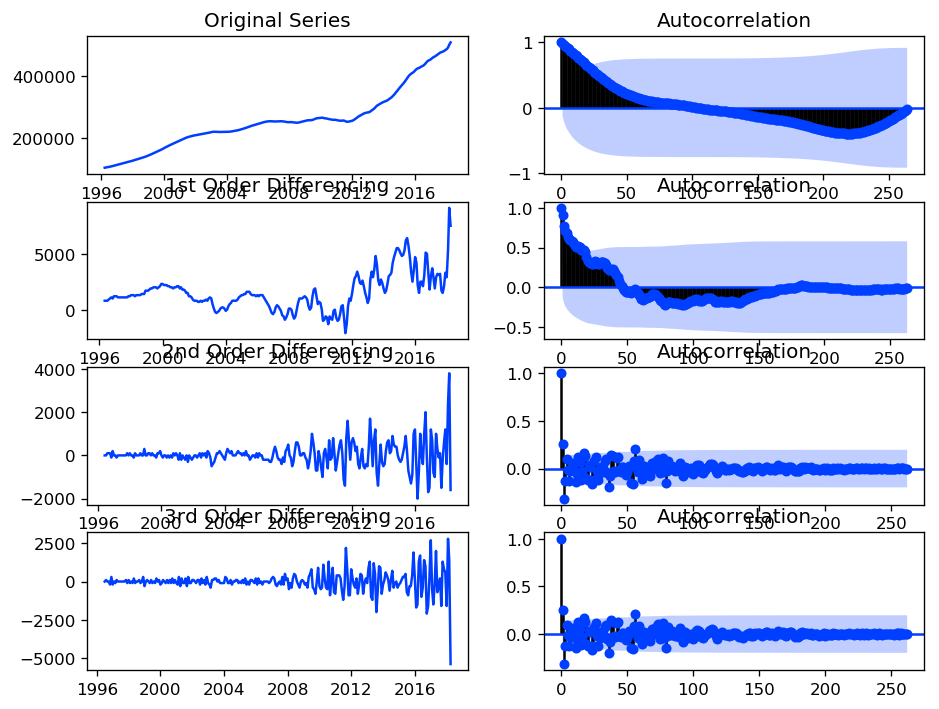

ZIPCODE:  80521


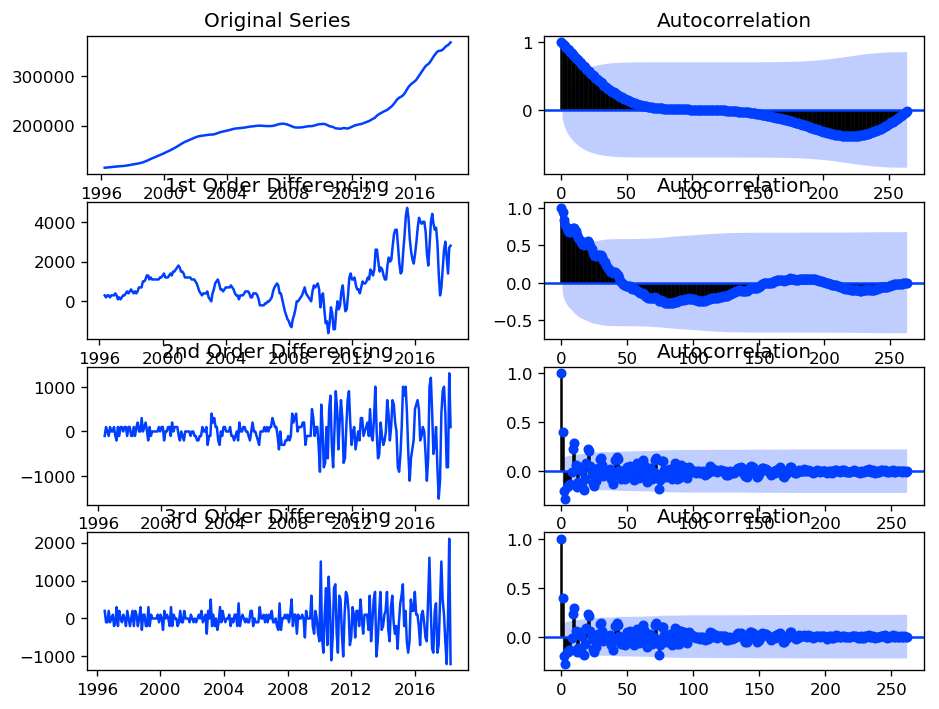

ZIPCODE:  80904


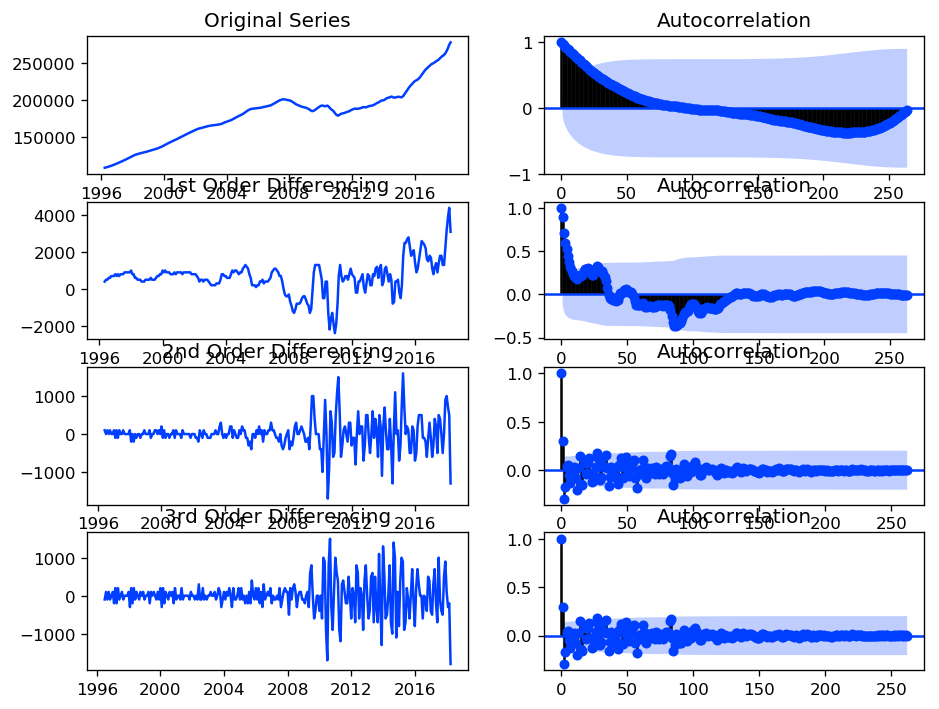

In [96]:
# check ACF and PACF

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Import data
for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
# Original Series
    print('ZIPCODE: ', z)
    fig, axes = plt.subplots(4, 2)
    axes[0, 0].plot(df_z.value); axes[0, 0].set_title('Original Series')
    plot_acf(df_z.value, ax=axes[0, 1])

    # 1st Differencing
    axes[1, 0].plot(df_z.value.diff()); axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df_z.value.diff().dropna(), ax=axes[1, 1])

    # 2nd Differencing
    axes[2, 0].plot(df_z.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
    plot_acf(df_z.value.diff().diff().dropna(), ax=axes[2, 1])
    
     # 3nd Differencing
    axes[3, 0].plot(df_z.value.diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
    plot_acf(df_z.value.diff().diff().dropna(), ax=axes[3, 1])


    plt.show()

We are not able to reduce heteroscedasticity

In [196]:
model.order

(3, 2, 4)

Zip:  37216
ADF Statistic Residual: -6.496969
p-value: 0.000000


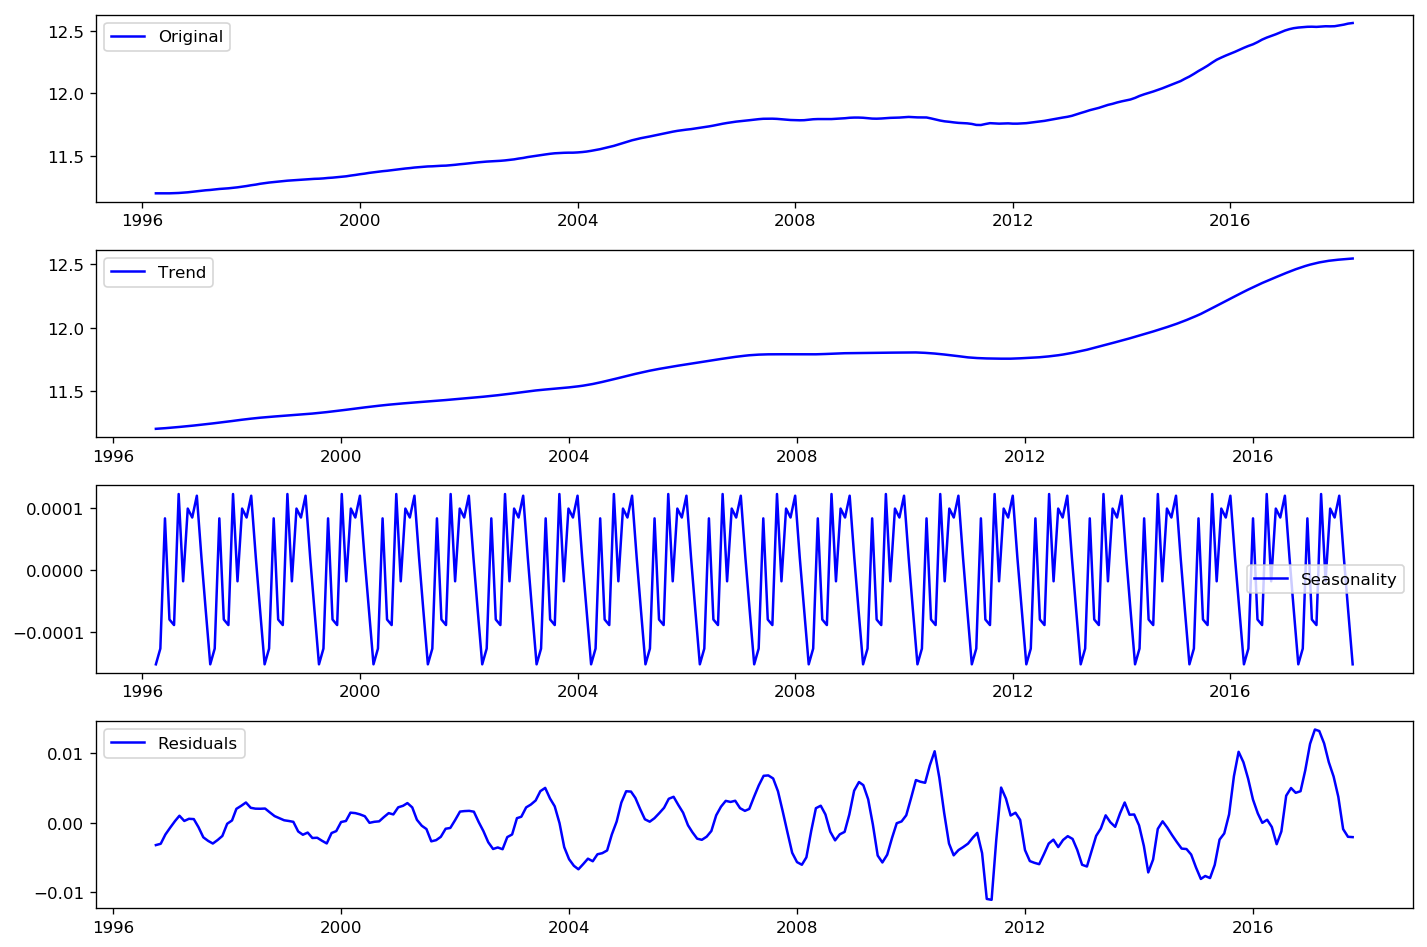

Fit ARIMA: order=(1, 2, 1); AIC=3746.099, BIC=3760.387, Fit time=0.076 seconds
Fit ARIMA: order=(0, 2, 0); AIC=3781.960, BIC=3789.105, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3773.693, BIC=3784.410, Fit time=0.014 seconds
Fit ARIMA: order=(0, 2, 1); AIC=3750.524, BIC=3761.241, Fit time=0.036 seconds
Fit ARIMA: order=(2, 2, 1); AIC=3724.742, BIC=3742.603, Fit time=0.073 seconds
Fit ARIMA: order=(2, 2, 0); AIC=3726.815, BIC=3741.103, Fit time=0.045 seconds
Fit ARIMA: order=(2, 2, 2); AIC=3726.408, BIC=3747.841, Fit time=0.119 seconds
Fit ARIMA: order=(3, 2, 2); AIC=3727.442, BIC=3752.447, Fit time=0.191 seconds
Fit ARIMA: order=(3, 2, 1); AIC=3725.459, BIC=3746.892, Fit time=0.167 seconds
Total fit time: 0.734 seconds
37216
                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  263
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1857.371
Method:         

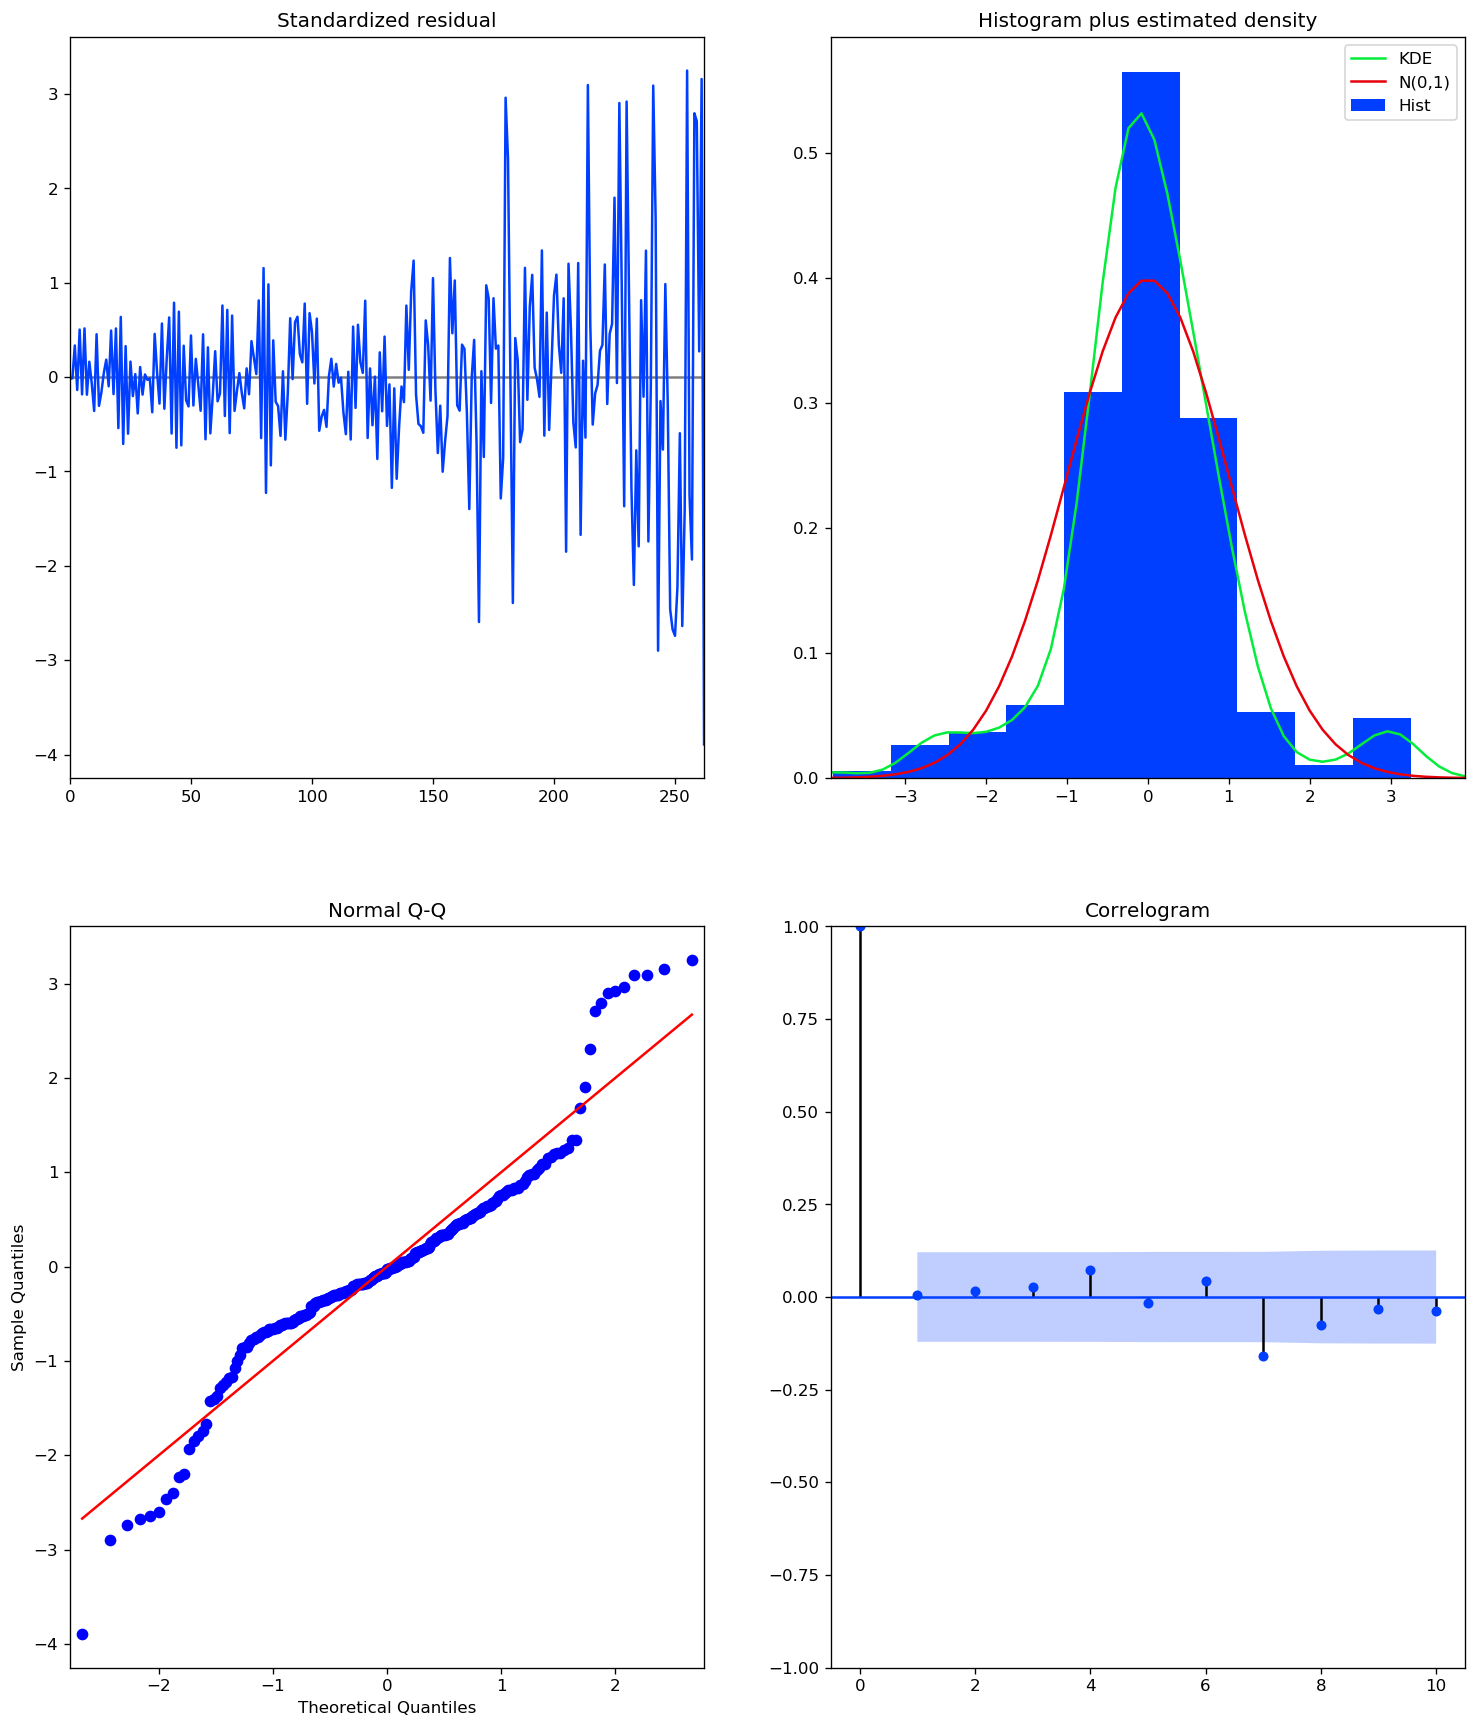

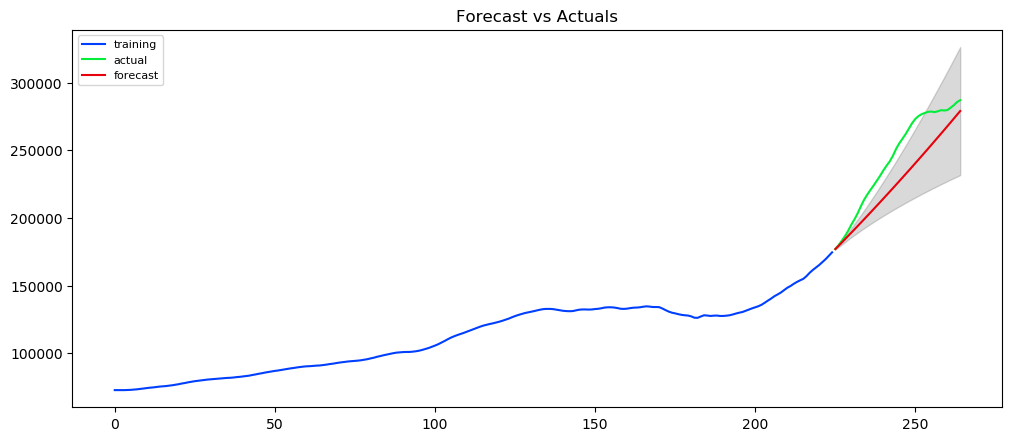

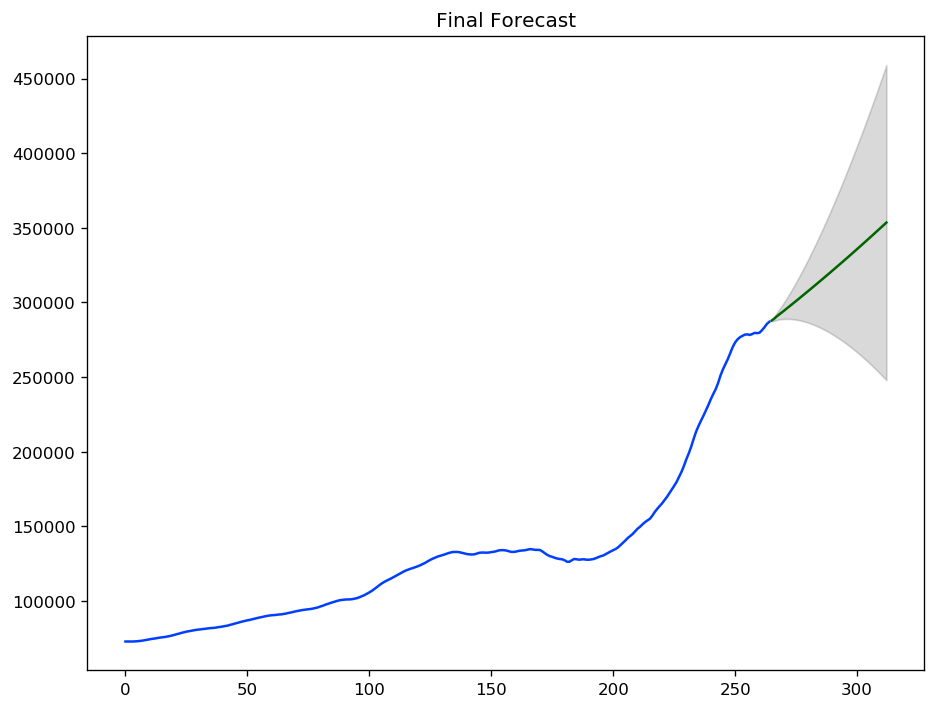

Zip:  80211
ADF Statistic Residual: -4.418188
p-value: 0.000276


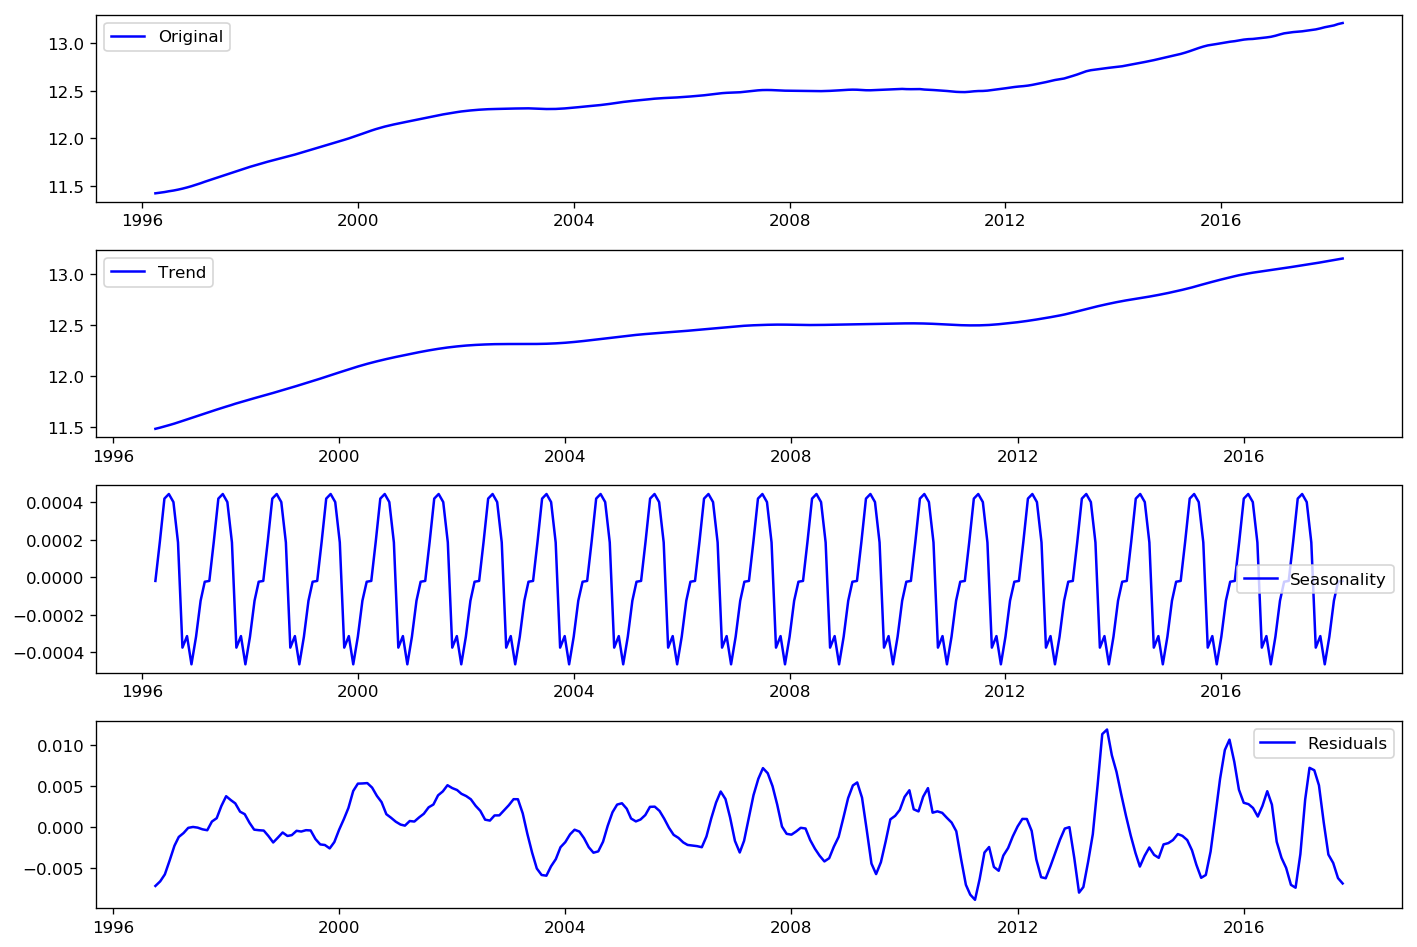

Fit ARIMA: order=(1, 2, 1); AIC=4003.166, BIC=4017.455, Fit time=0.084 seconds
Fit ARIMA: order=(0, 2, 0); AIC=4053.545, BIC=4060.689, Fit time=0.003 seconds
Fit ARIMA: order=(1, 2, 0); AIC=4041.428, BIC=4052.145, Fit time=0.015 seconds
Fit ARIMA: order=(0, 2, 1); AIC=4006.747, BIC=4017.463, Fit time=0.026 seconds
Fit ARIMA: order=(2, 2, 1); AIC=3982.181, BIC=4000.042, Fit time=0.092 seconds
Fit ARIMA: order=(2, 2, 0); AIC=4000.196, BIC=4014.485, Fit time=0.050 seconds
Fit ARIMA: order=(2, 2, 2); AIC=3961.733, BIC=3983.166, Fit time=0.108 seconds
Fit ARIMA: order=(3, 2, 3); AIC=3959.089, BIC=3987.667, Fit time=0.262 seconds
Fit ARIMA: order=(2, 2, 3); AIC=3960.338, BIC=3985.343, Fit time=0.246 seconds
Fit ARIMA: order=(4, 2, 3); AIC=3952.440, BIC=3984.590, Fit time=0.389 seconds
Fit ARIMA: order=(4, 2, 2); AIC=3951.957, BIC=3980.534, Fit time=0.221 seconds
Fit ARIMA: order=(3, 2, 1); AIC=3977.699, BIC=3999.132, Fit time=0.105 seconds
Fit ARIMA: order=(5, 2, 3); AIC=nan, BIC=nan, Fit ti

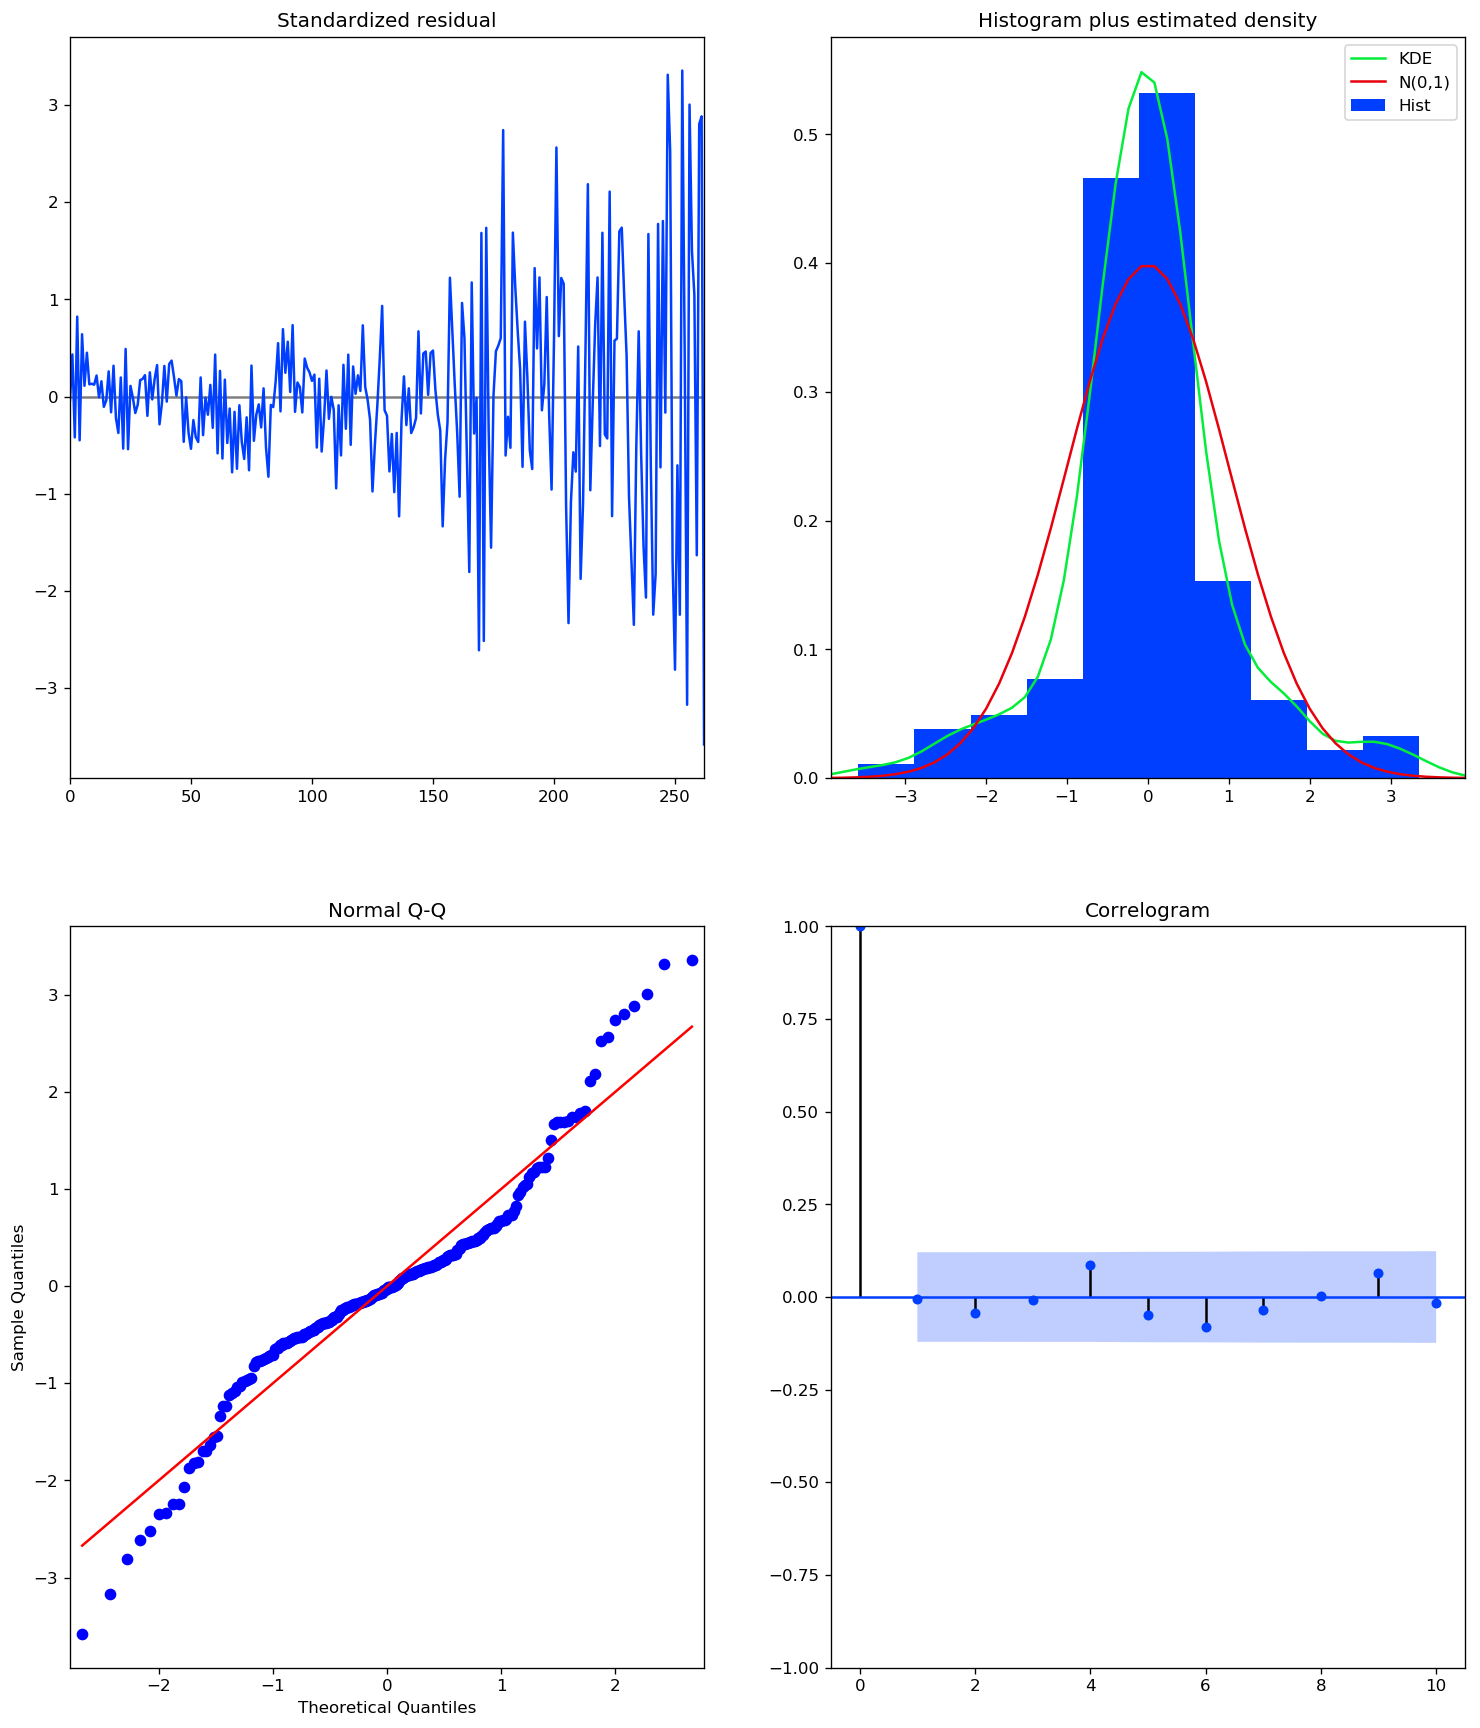

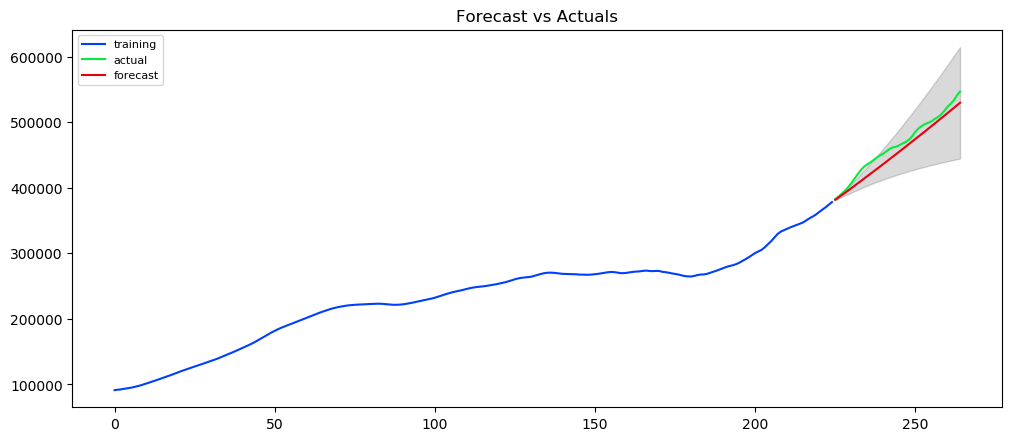

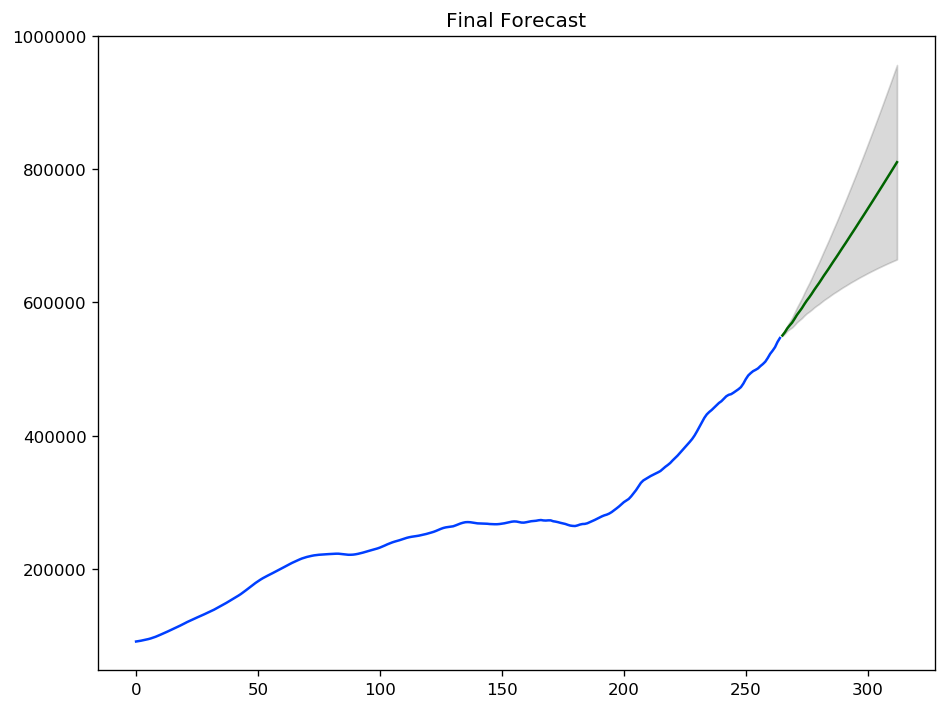

Zip:  80212
ADF Statistic Residual: -4.702324
p-value: 0.000083


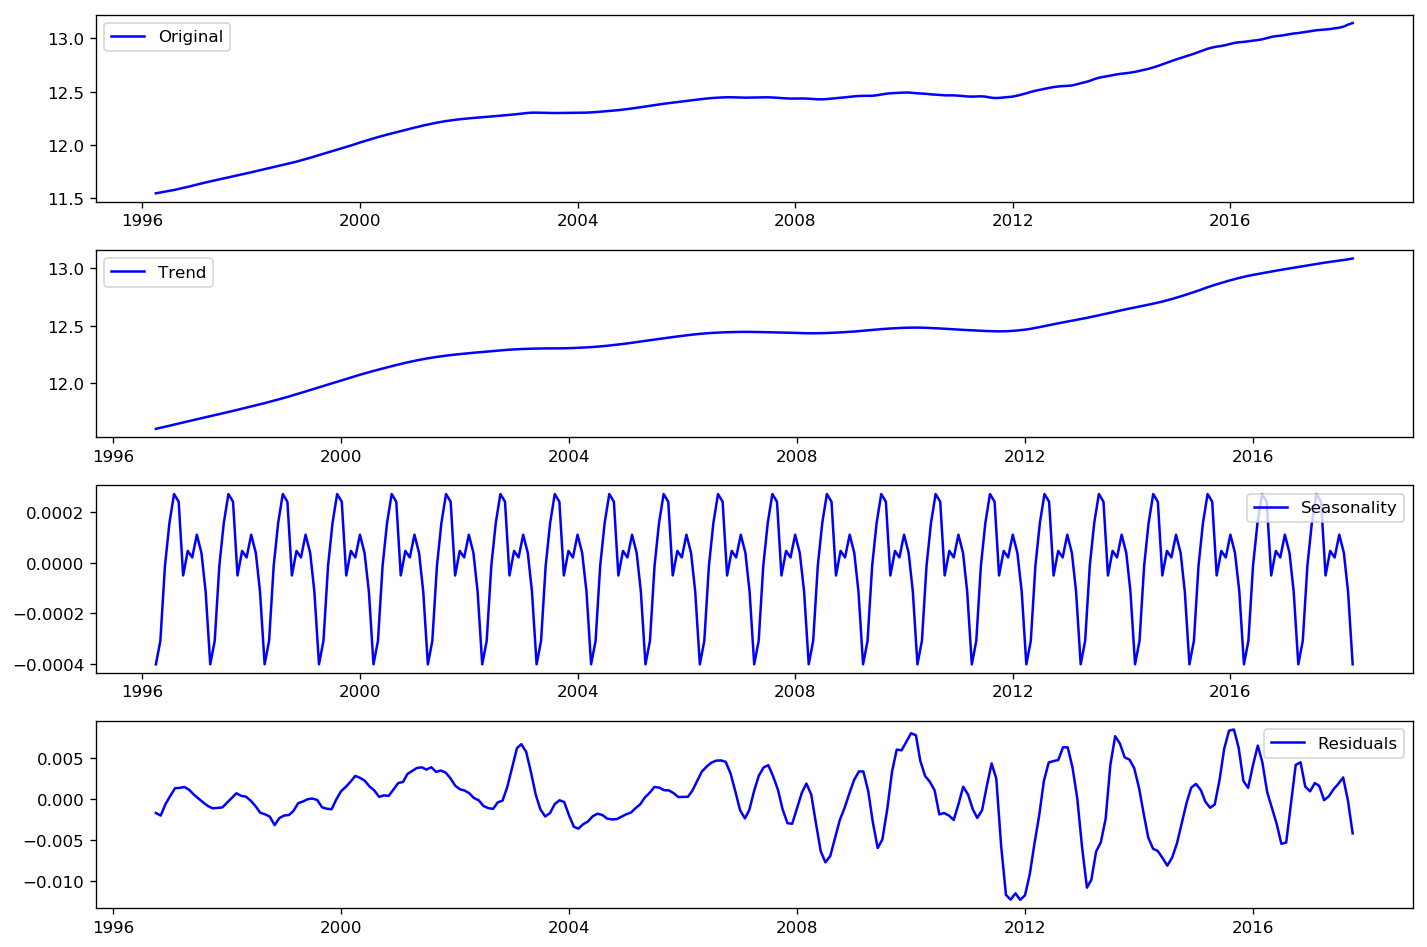

Fit ARIMA: order=(1, 2, 1); AIC=4037.124, BIC=4051.413, Fit time=0.079 seconds
Fit ARIMA: order=(0, 2, 0); AIC=4097.748, BIC=4104.893, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=4081.572, BIC=4092.288, Fit time=0.016 seconds
Fit ARIMA: order=(0, 2, 1); AIC=4038.479, BIC=4049.195, Fit time=0.046 seconds
Fit ARIMA: order=(2, 2, 1); AIC=4002.618, BIC=4020.479, Fit time=0.092 seconds
Fit ARIMA: order=(2, 2, 0); AIC=4010.428, BIC=4024.717, Fit time=0.034 seconds
Fit ARIMA: order=(2, 2, 2); AIC=3983.365, BIC=4004.798, Fit time=0.183 seconds
Fit ARIMA: order=(3, 2, 3); AIC=3978.305, BIC=4006.882, Fit time=0.275 seconds
Fit ARIMA: order=(2, 2, 3); AIC=3985.286, BIC=4010.291, Fit time=0.289 seconds
Fit ARIMA: order=(4, 2, 3); AIC=3977.112, BIC=4009.262, Fit time=0.405 seconds
Fit ARIMA: order=(4, 2, 2); AIC=3999.300, BIC=4027.877, Fit time=0.245 seconds
Fit ARIMA: order=(4, 2, 4); AIC=nan, BIC=nan, Fit time=0.285 seconds
Fit ARIMA: order=(3, 2, 2); AIC=3985.343, BIC=4010.348, Fit ti

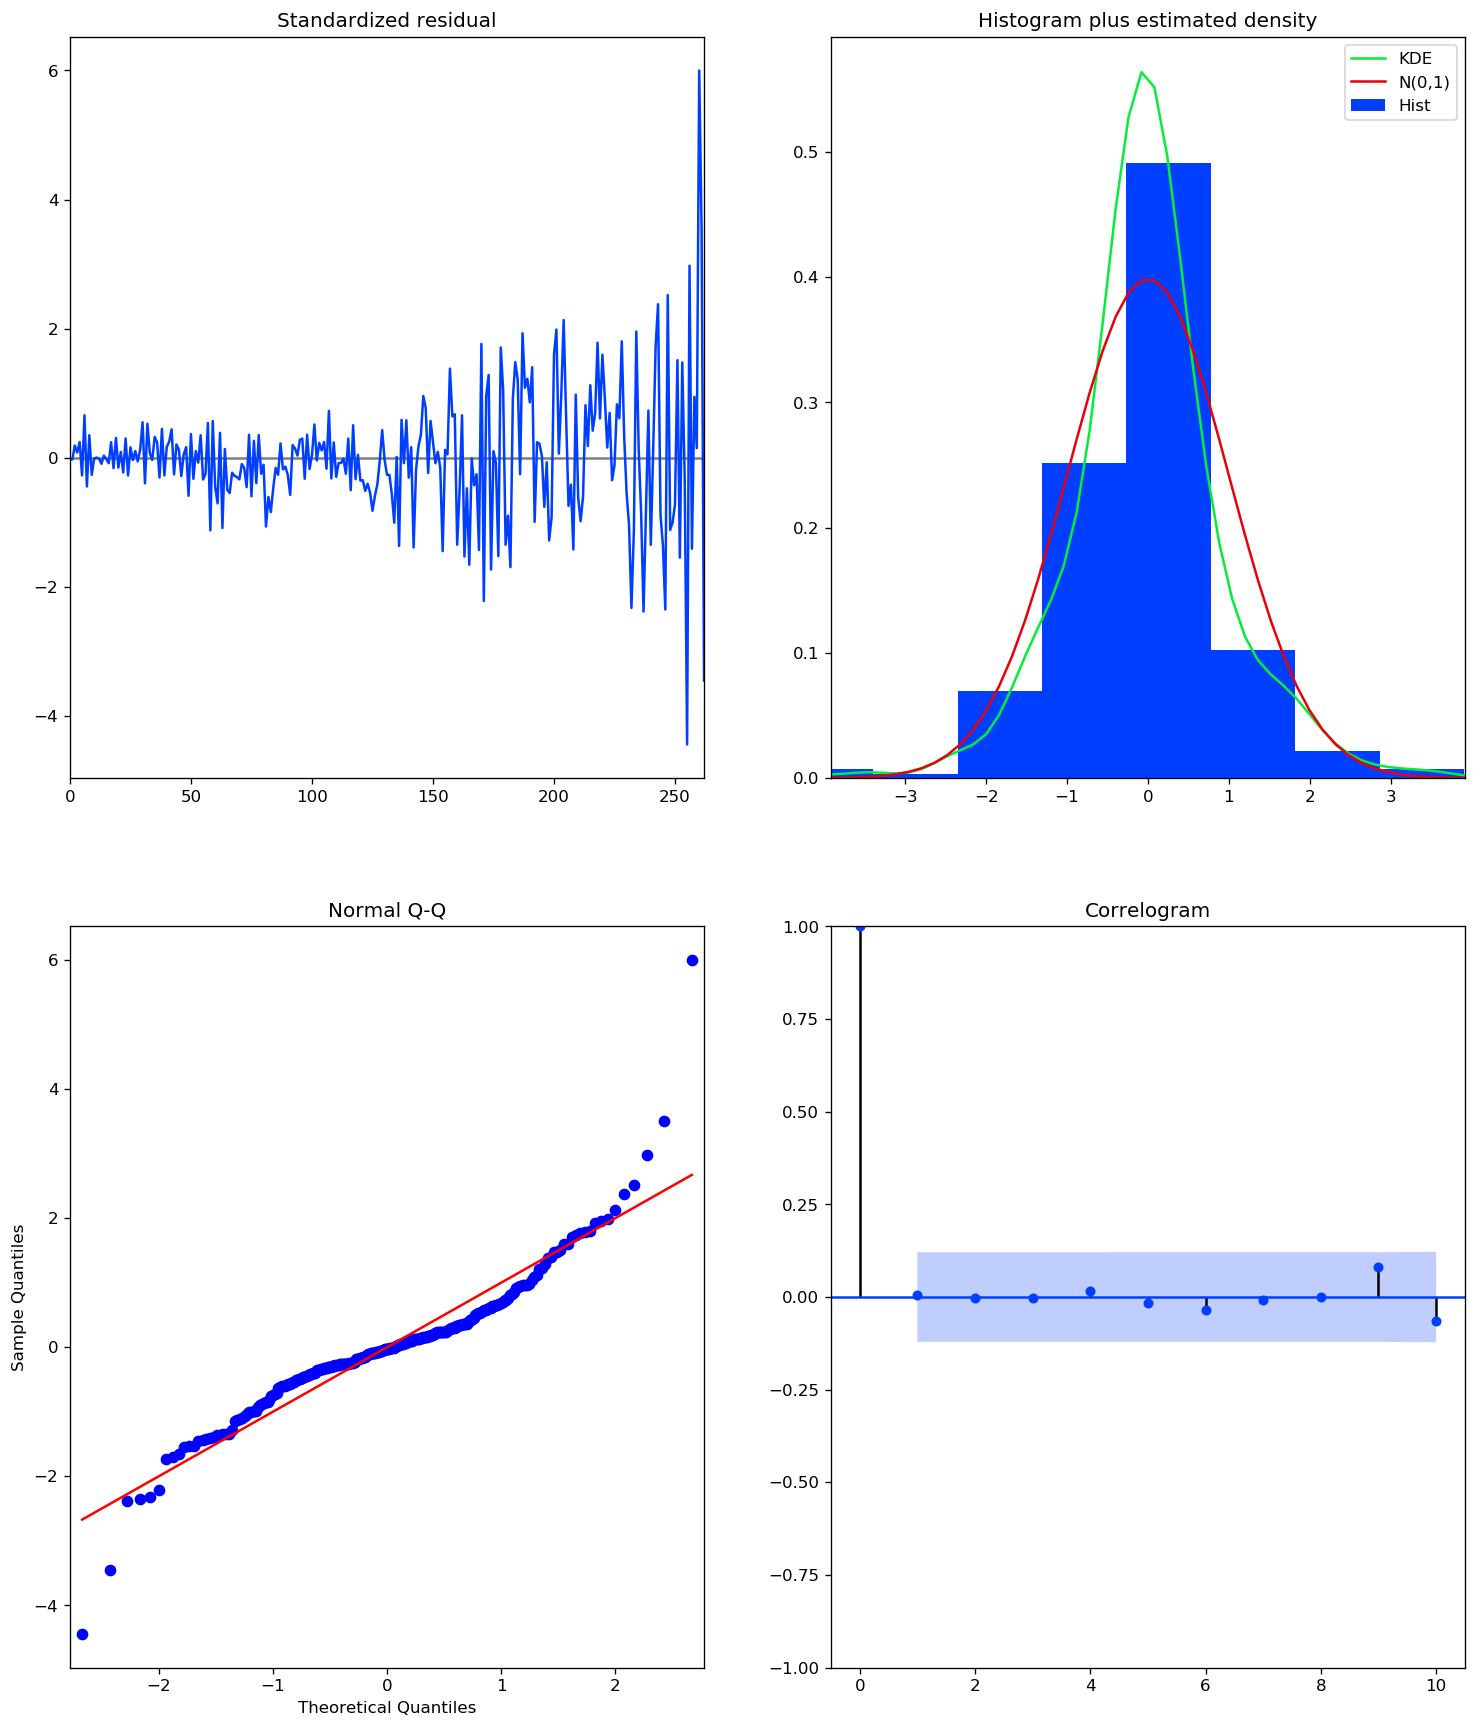

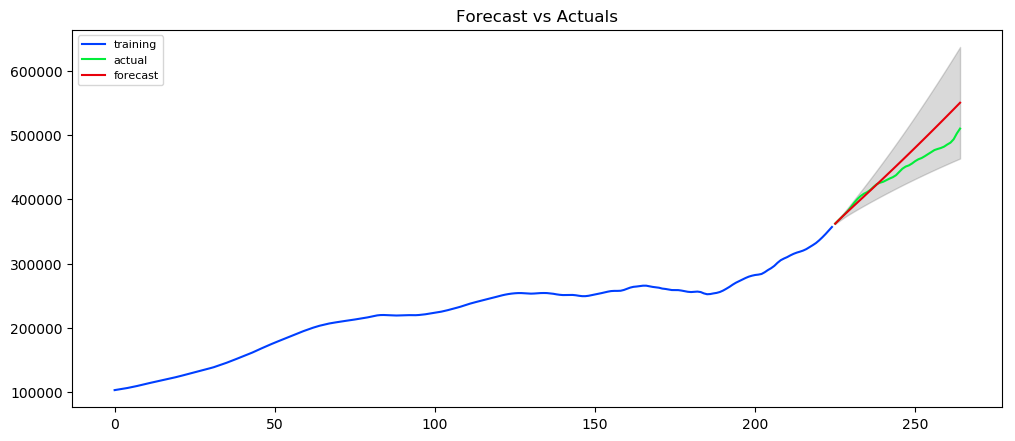

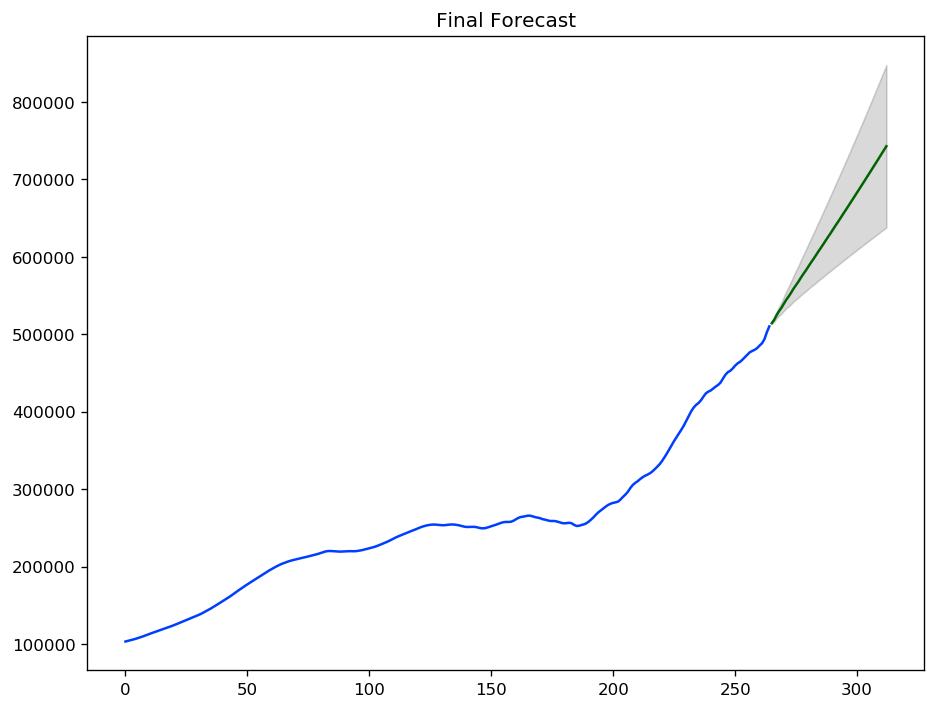

Zip:  80521
ADF Statistic Residual: -3.809518
p-value: 0.002811


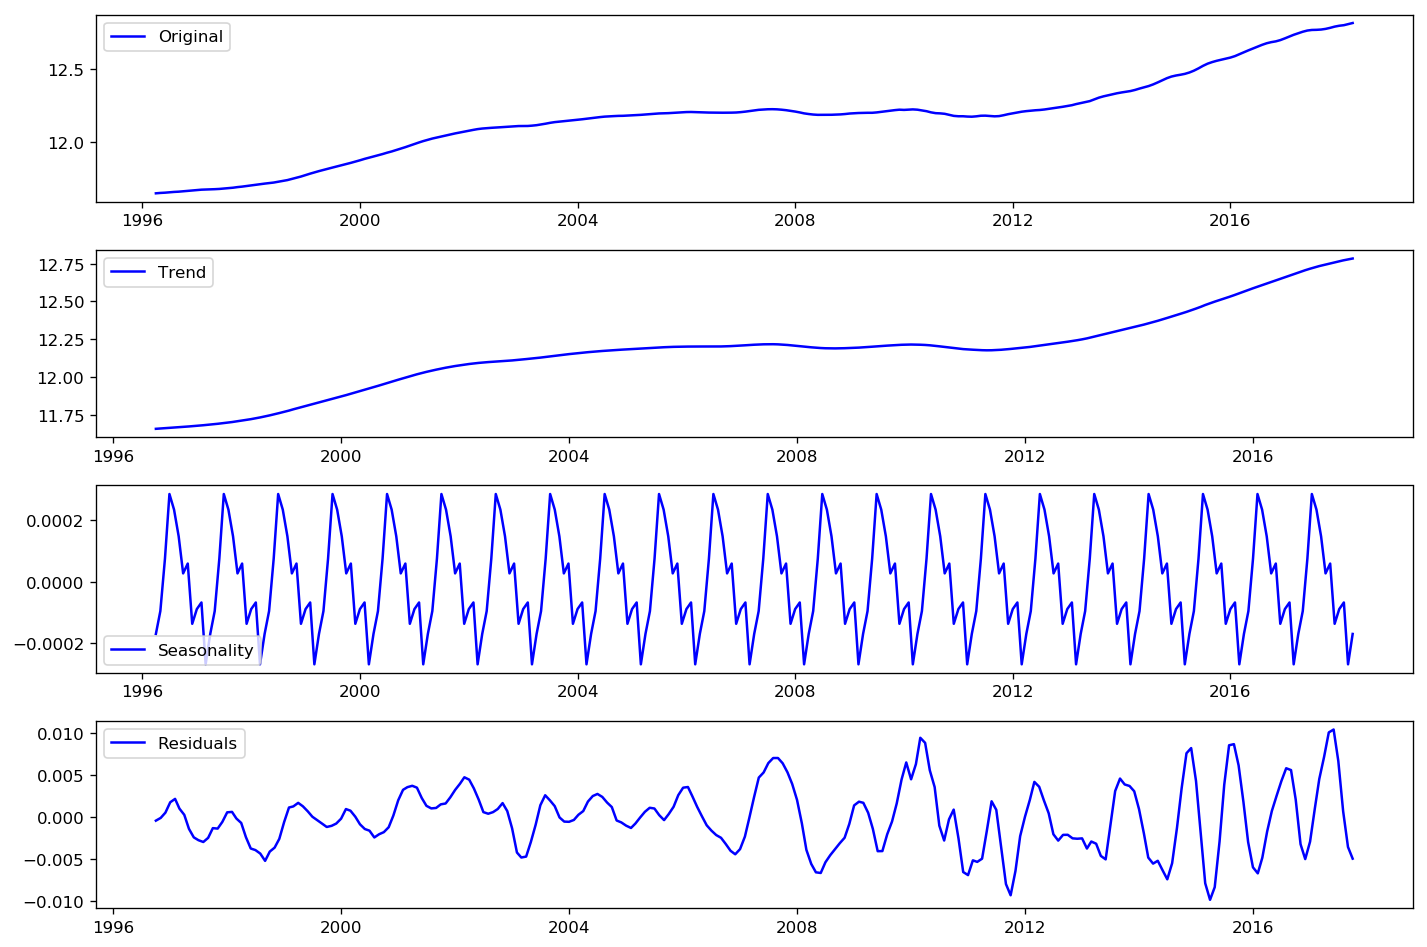

Fit ARIMA: order=(1, 2, 1); AIC=3800.813, BIC=3815.102, Fit time=0.079 seconds
Fit ARIMA: order=(0, 2, 0); AIC=3877.846, BIC=3884.991, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3835.212, BIC=3845.929, Fit time=0.033 seconds
Fit ARIMA: order=(0, 2, 1); AIC=3799.011, BIC=3809.727, Fit time=0.027 seconds
Fit ARIMA: order=(0, 2, 2); AIC=3800.475, BIC=3814.764, Fit time=0.046 seconds
Fit ARIMA: order=(1, 2, 2); AIC=3781.709, BIC=3799.570, Fit time=0.123 seconds
Fit ARIMA: order=(2, 2, 2); AIC=3770.882, BIC=3792.315, Fit time=0.143 seconds
Fit ARIMA: order=(2, 2, 1); AIC=3784.353, BIC=3802.213, Fit time=0.112 seconds
Fit ARIMA: order=(2, 2, 3); AIC=3765.197, BIC=3790.202, Fit time=0.182 seconds
Fit ARIMA: order=(3, 2, 4); AIC=3767.856, BIC=3800.005, Fit time=0.342 seconds
Fit ARIMA: order=(1, 2, 3); AIC=3764.291, BIC=3785.724, Fit time=0.148 seconds
Fit ARIMA: order=(1, 2, 4); AIC=3765.579, BIC=3790.585, Fit time=0.234 seconds
Fit ARIMA: order=(2, 2, 4); AIC=3767.196, BIC=3795.7

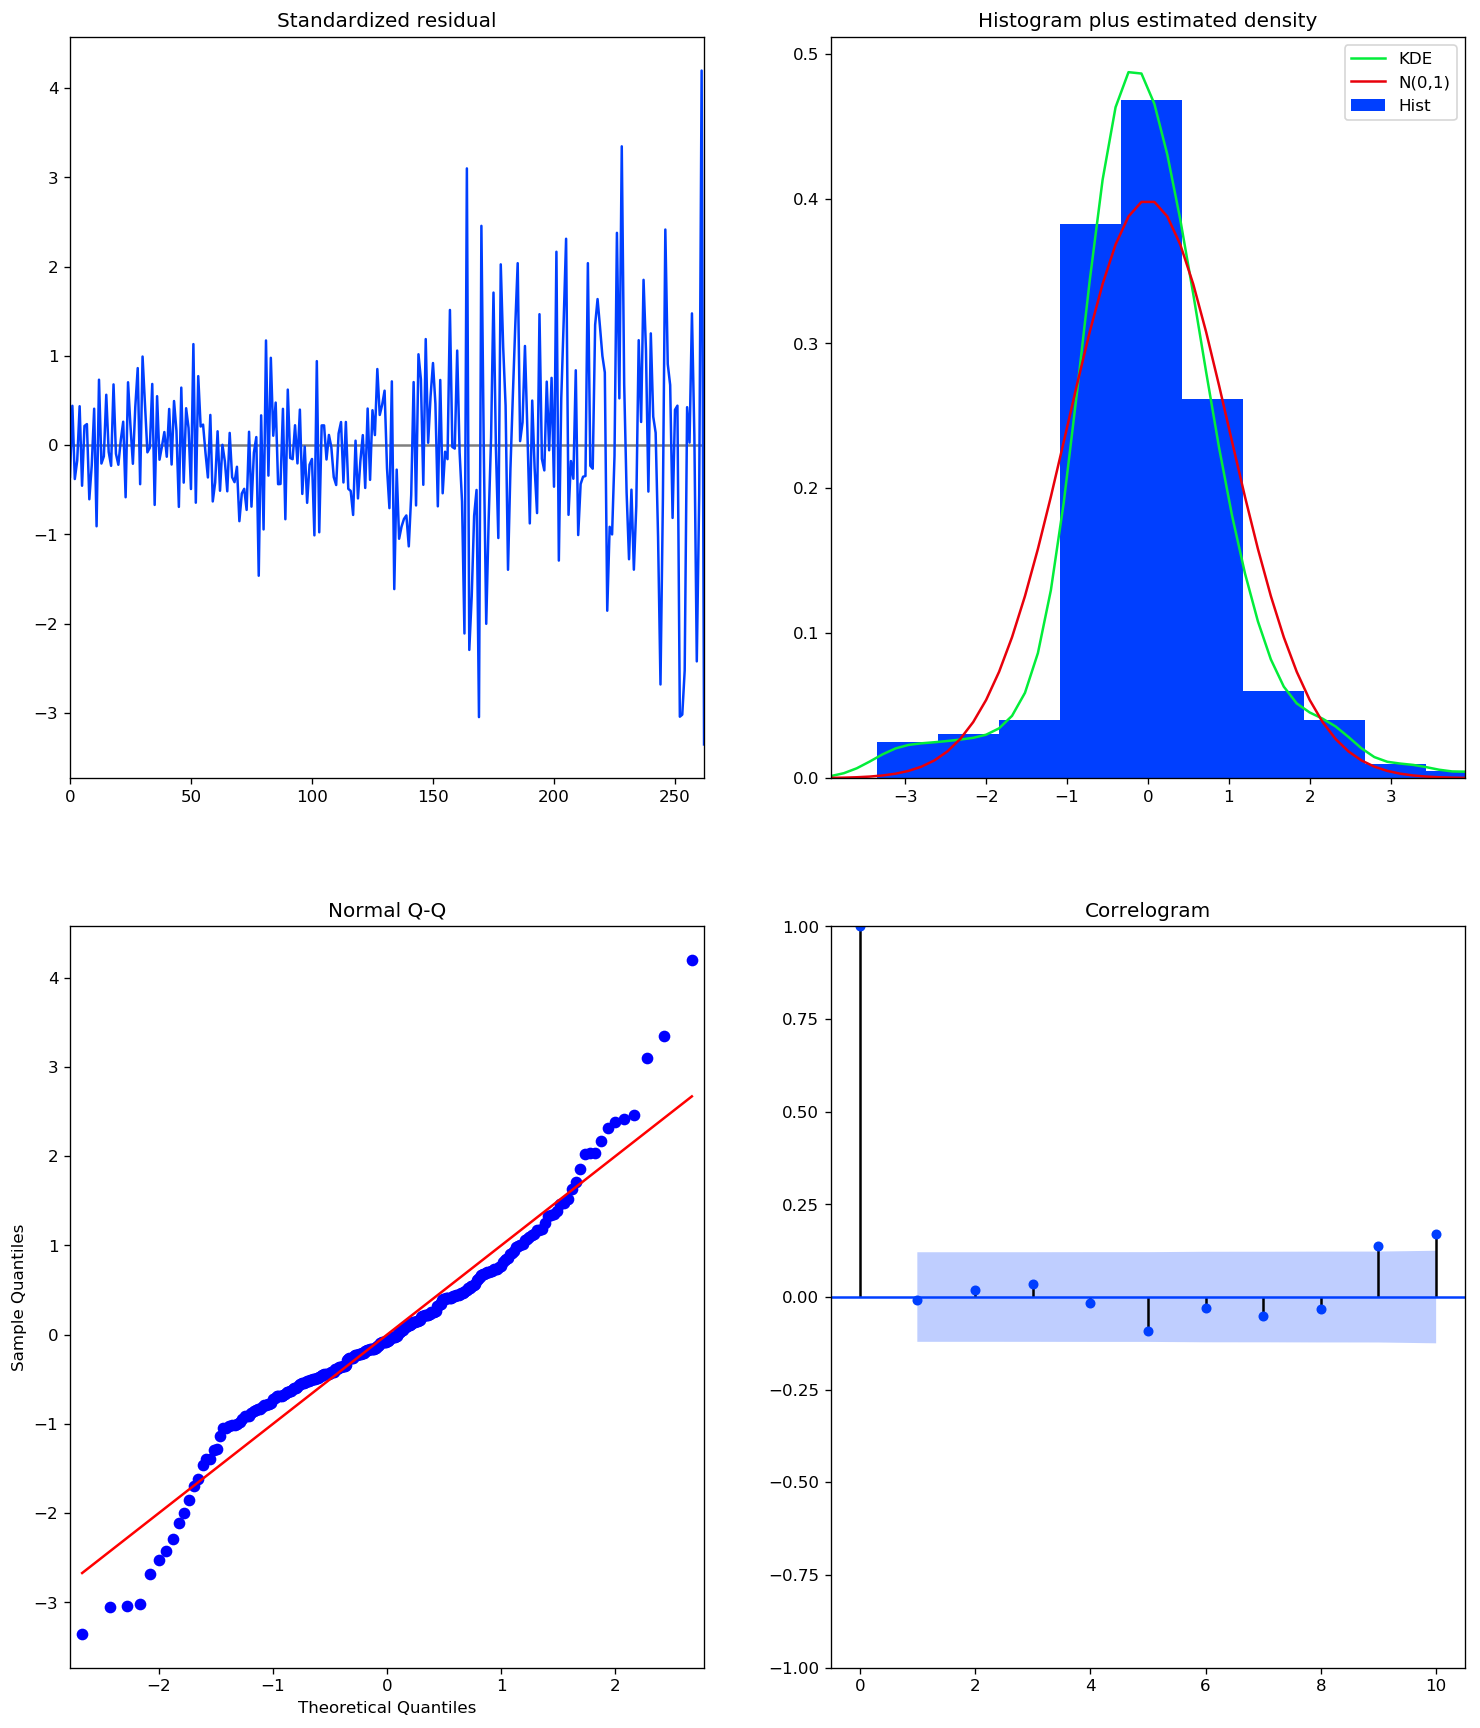

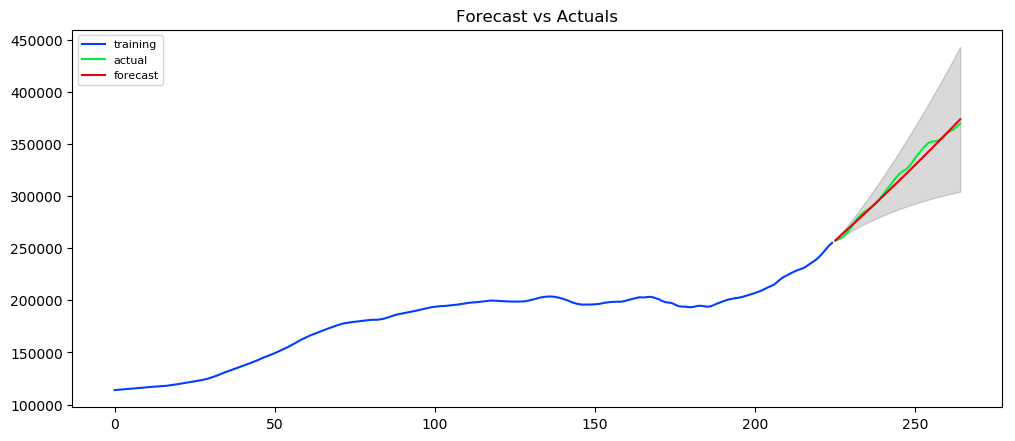

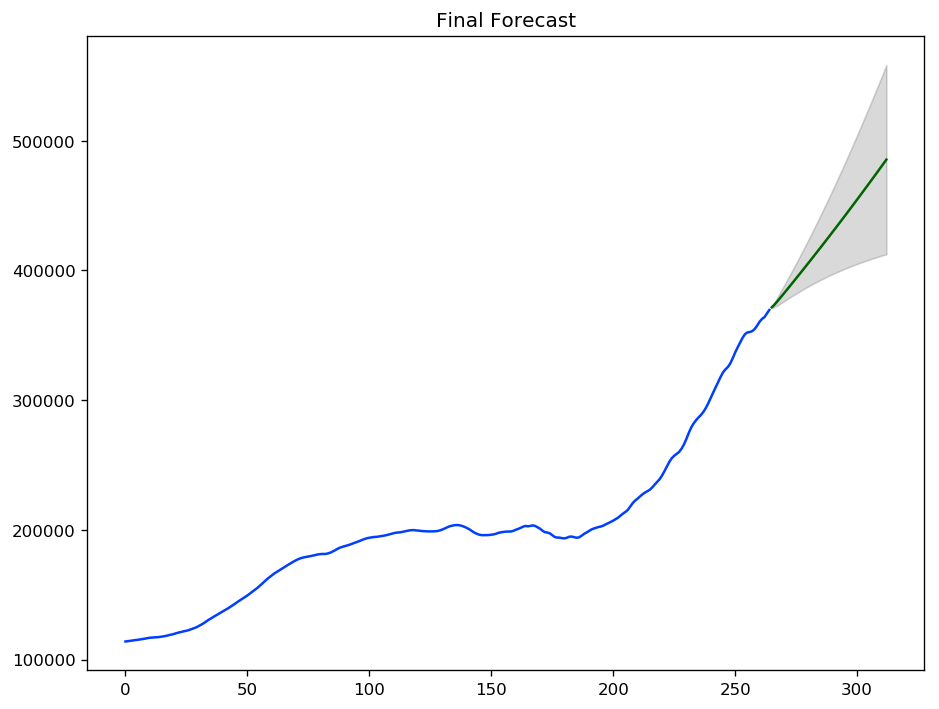

Zip:  80904
ADF Statistic Residual: -5.548130
p-value: 0.000002


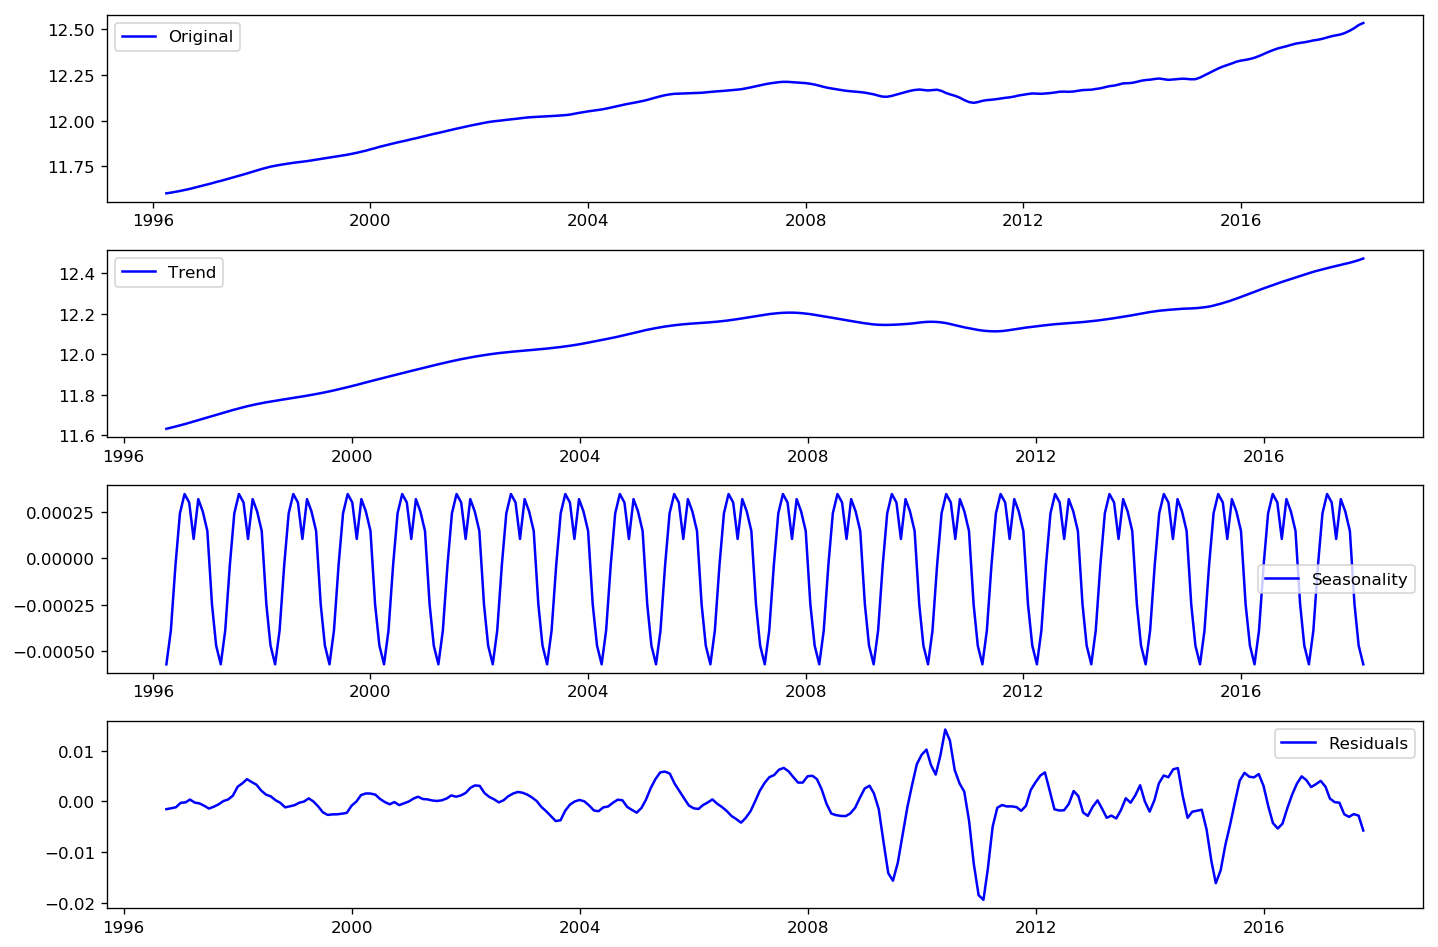

Fit ARIMA: order=(1, 2, 1); AIC=3807.263, BIC=3821.552, Fit time=0.086 seconds
Fit ARIMA: order=(0, 2, 0); AIC=3874.927, BIC=3882.071, Fit time=0.002 seconds
Fit ARIMA: order=(1, 2, 0); AIC=3851.623, BIC=3862.339, Fit time=0.026 seconds
Fit ARIMA: order=(0, 2, 1); AIC=3806.757, BIC=3817.474, Fit time=0.032 seconds
Fit ARIMA: order=(0, 2, 2); AIC=3804.791, BIC=3819.079, Fit time=0.050 seconds
Fit ARIMA: order=(1, 2, 3); AIC=3783.795, BIC=3805.228, Fit time=0.144 seconds
Fit ARIMA: order=(0, 2, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 3); AIC=3781.880, BIC=3806.885, Fit time=0.208 seconds
Fit ARIMA: order=(2, 2, 2); AIC=3792.056, BIC=3813.489, Fit time=0.132 seconds
Fit ARIMA: order=(2, 2, 4); AIC=3782.125, BIC=3810.703, Fit time=0.335 seconds
Fit ARIMA: order=(1, 2, 2); AIC=3784.831, BIC=3802.691, Fit time=0.136 seconds
Fit ARIMA: order=(3, 2, 4); AIC=3775.525, BIC=3807.675, Fit time=0.570 seconds
Fit ARIMA: order=(4, 2, 4); AIC=3777.152, BIC=3812.873, Fit time

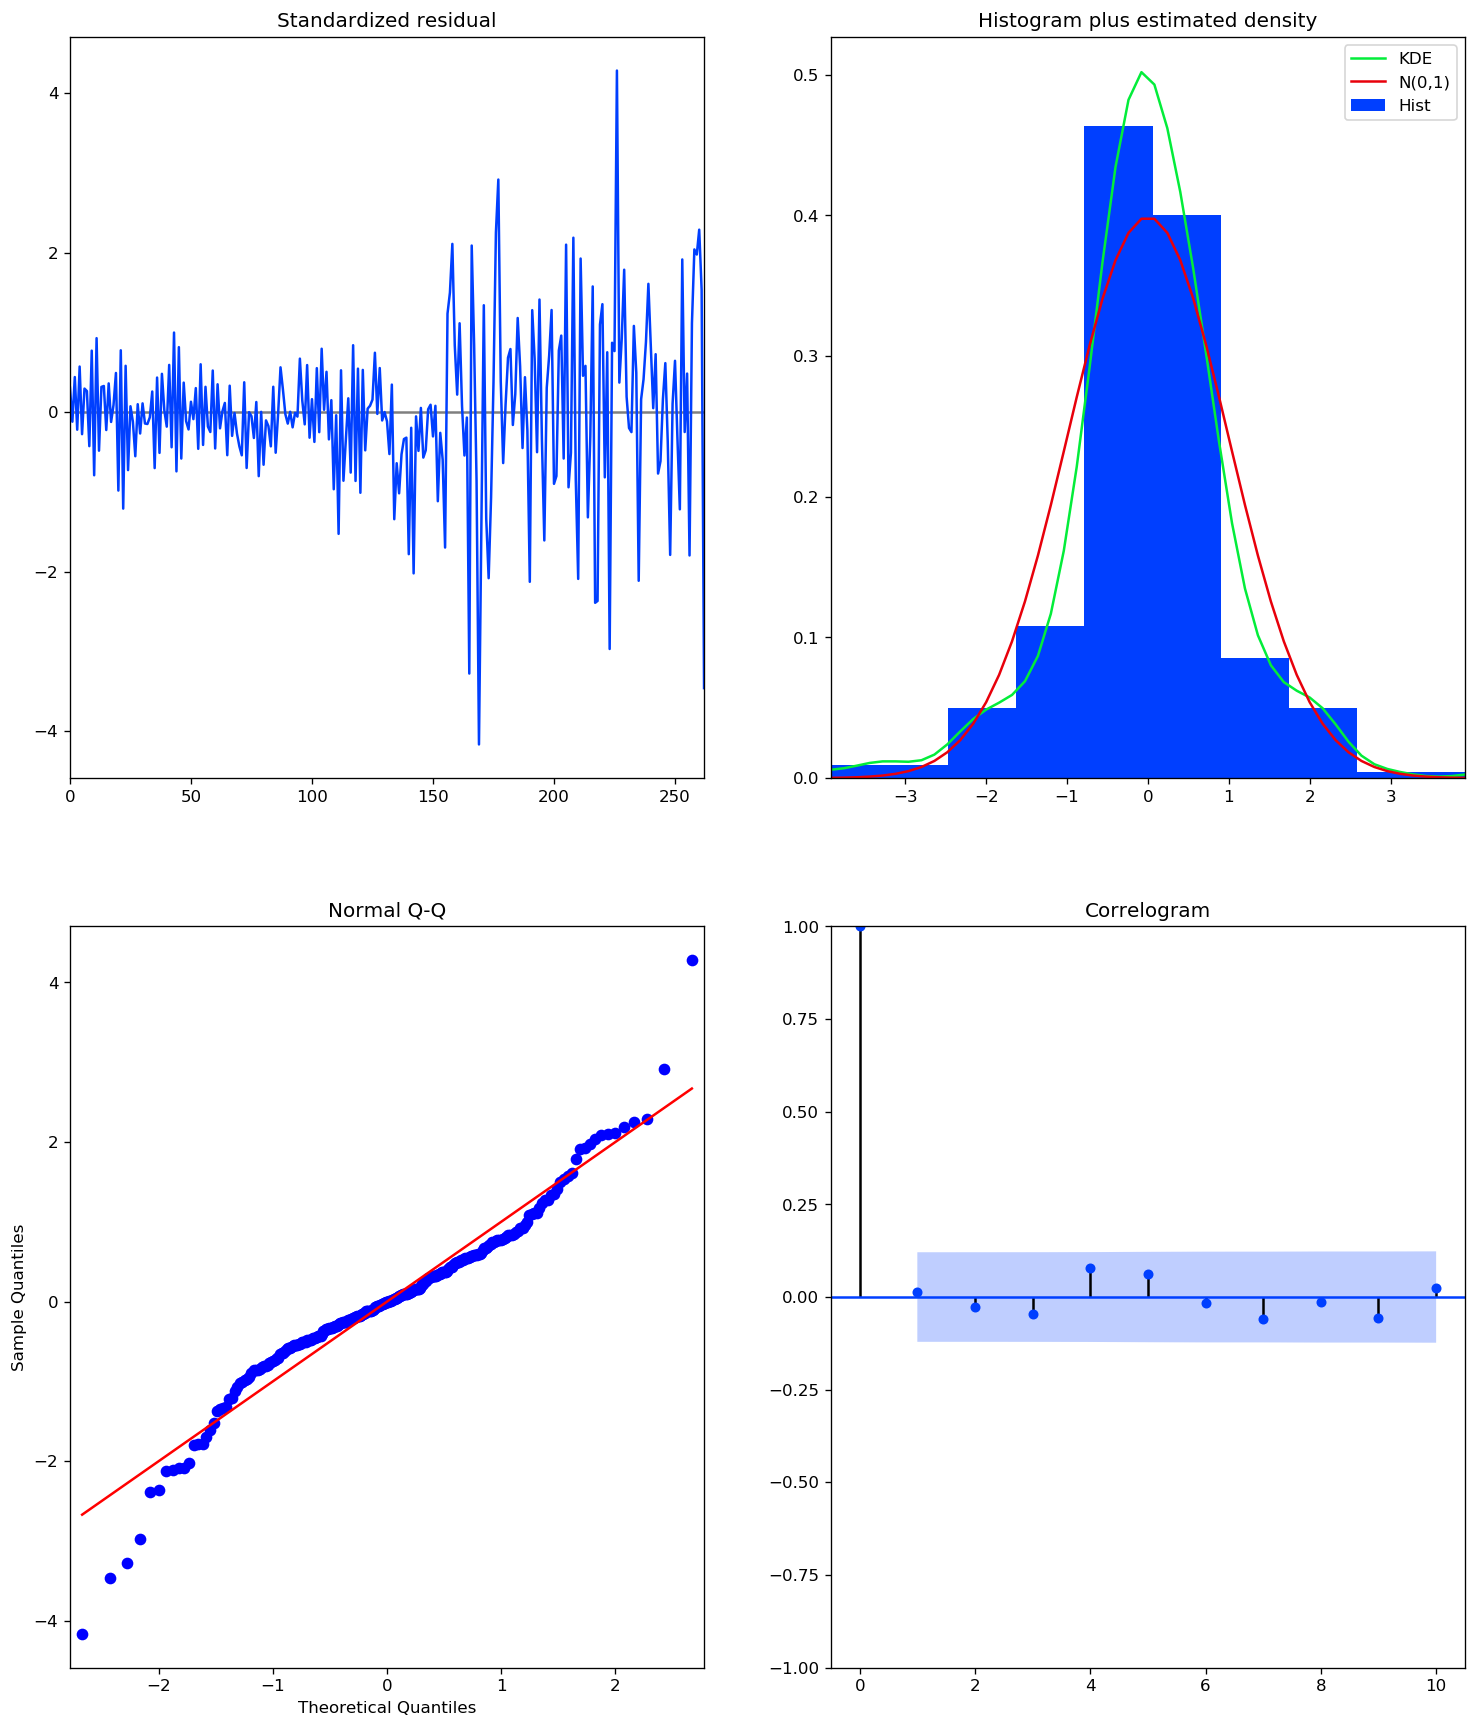

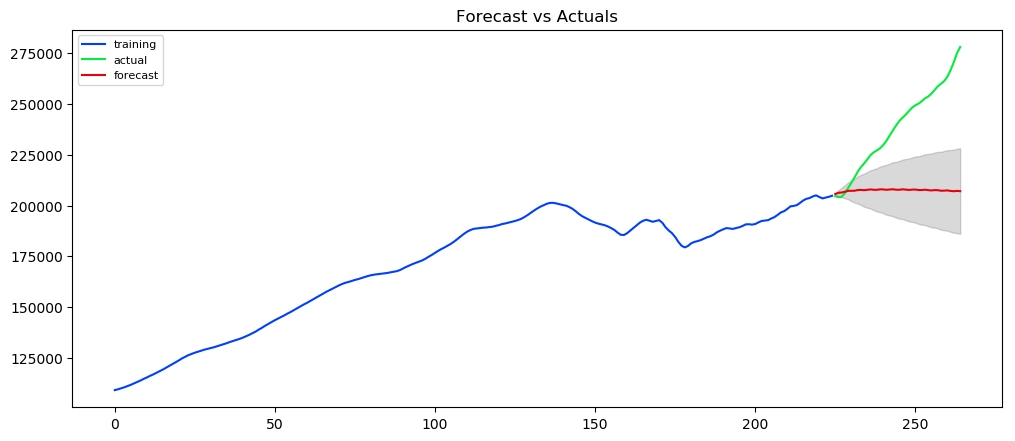

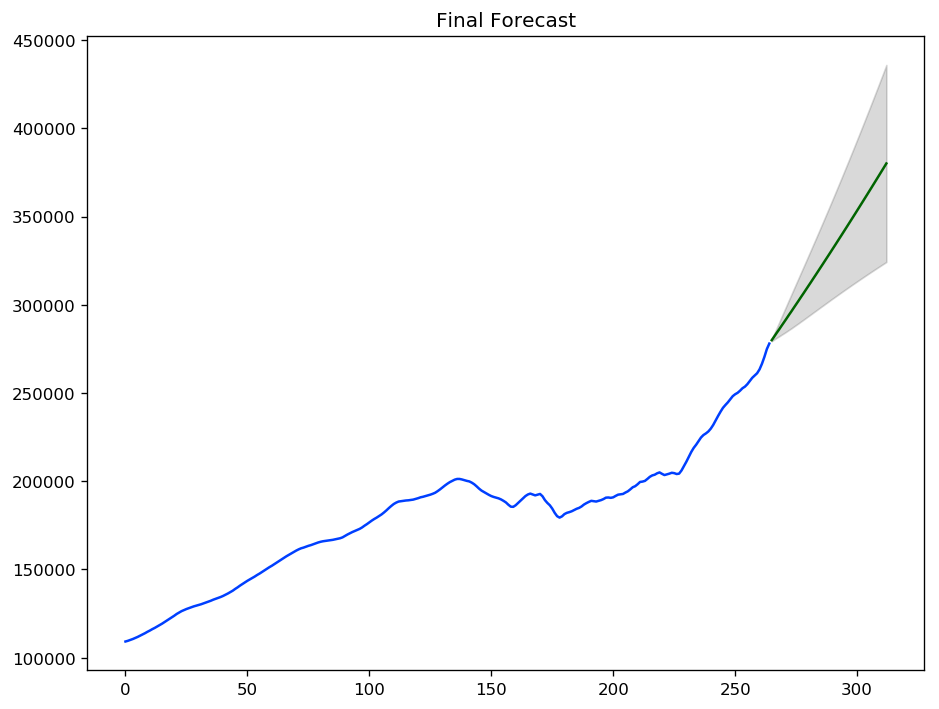

In [201]:

# compute residuals and create an ARMA model of the residuals.

from statsmodels.tsa.seasonal import seasonal_decompose

residuals_list = []
for z in zipcodes: 
    df_z = zip_df[zip_df.RegionName == z]
    ts = df_z.value
    decomposition = seasonal_decompose(np.log(ts))

    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    df_z['res'] = residual
    residuals_list.append(residual)
    
    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color="blue")
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color="blue")
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color="blue")
    plt.legend(loc='best')
    plt.tight_layout()
    result = adfuller(residual.dropna())
    print('Zip: ', z)
    print('ADF Statistic Residual: %f' % result[0])
    print('p-value: %f' % result[1])
    plt.show()
    

    model = pm.auto_arima(df_z.value.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(z)
    print(model.summary())
    model.plot_diagnostics(figsize=(15, 18))
    plt.show()
    
    #============= PLOT TRAIN AND TEST =========
    df_z.reset_index(inplace=True)
    train = df_z.value[:225]
    test = df_z.value[225:]
    
    model2 = ARIMA(train, order=model.order)
    fitted = model2.fit(disp=-1)  
                   
    # Forecast
    fc, se, conf = fitted.forecast(40, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    
    
    #==============PLOT FORECAST =========================
    df_z.reset_index(inplace=True)
    n_periods = 48
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = np.arange(len(df_z.value), len(df_z.value)+n_periods)

    # make series for plotting purpose
    fc_series = pd.Series(fc, index=(index_of_fc))
    lower_series = pd.Series(confint[:, 0], index=(index_of_fc))
    upper_series = pd.Series(confint[:, 1], index=(index_of_fc))

    # Plot
    plt.plot(df_z.value)
    plt.plot(fc_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("Final Forecast")
    plt.show()

  

# Step 6: Interpreting Results